# Tuned Logistic Regression Model

Testing the model with hyperparameter tunning.

__Imports__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import jupyterthemes as jt
# context = jt.jtplot.set_context('paper')
# jt.stylefx.style_layout('nb_style', theme='monokai',
#                         toolbar=True, nbname=True, cellwidth='1000')
# jt.stylefx.set_nb_theme('monokai')

In [2]:
# Changes plot style. Also not necessary.
# jt.jtplot.set_style(context, 'monokai', ticks=True, spines=True)


## Read in the data and instantiate logistic regression model

In [3]:
df = pd.read_csv("../data/device_failure_data_scientist.csv")
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


In [4]:
features = df.drop(columns=['date', 'device', 'failure'])
labels = df['failure']

In [5]:
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
    shuffle=False,
)

In [6]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [7]:
lr = LogisticRegression(penalty='elasticnet',
                        C=0.0001,
                        max_iter=500,
                        class_weight='balanced',
                        solver='saga',
                        l1_ratio=0.65,
                        random_state=42)

lr.fit(X_train_ss, y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.65,
                   max_iter=500, multi_class='warn', n_jobs=None,
                   penalty='elasticnet', random_state=42, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

## LogReg metrics

Accuracy right in line with baseline model

In [8]:
lr.score(X_train_ss, y_train)

0.9840955338973975

In [9]:
lr.score(X_test_ss, y_test)
# accuracy = 0.947

0.9750032129546331

In [10]:
np.exp(lr.coef_)

array([[1.        , 1.10065145, 1.        , 1.18632597, 1.        ,
        1.        , 1.24530014, 1.24530014, 1.        ]])

**Coefficients (odds of failing):**

- `attribute1` = $1.00$
- `attribute2` = $1.10$
- `attribute3` = $1.00$
- `attribute4` = $1.18$
- `attribute5` = $1.00$
- `attribute6` = $1.00$
- `attribute7` = $1.25$
- `attribute8` = $1.25$
- `attribute9` = $1.00$

In [11]:
# Generate predictions.
preds = lr.predict(X_test_ss)

In [12]:
# Generate confusion matrix.
confusion_matrix(
    y_test,  # True values.
    preds)  # Predicted values

array([[30335,   763],
       [   15,    11]], dtype=int64)

In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [14]:
# Specificity and Sensitivity

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec, 4)}')
print(f'Sensitivity: {round(sens, 4)}')

Specificity: 0.9755
Sensitivity: 0.4231


$$specificity = 0.976$$

$$sensitivity = 0.423$$

### ROC AUC 

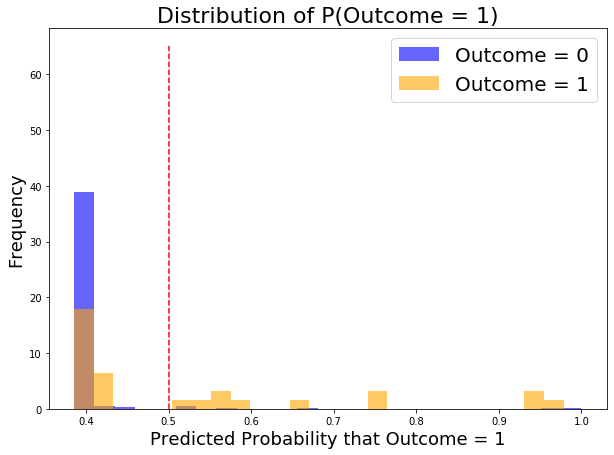

In [18]:
pred_proba = [i[1] for i in lr.predict_proba(X_test_ss)]

pred_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_proba})

# Create figure.
plt.figure(figsize=(10, 7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha=0.6,
         label='Outcome = 0',
         density=True)

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha=0.6,
         label='Outcome = 1',
         density=True)

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5, ymin=0, ymax=65, color='r', linestyle='--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20)

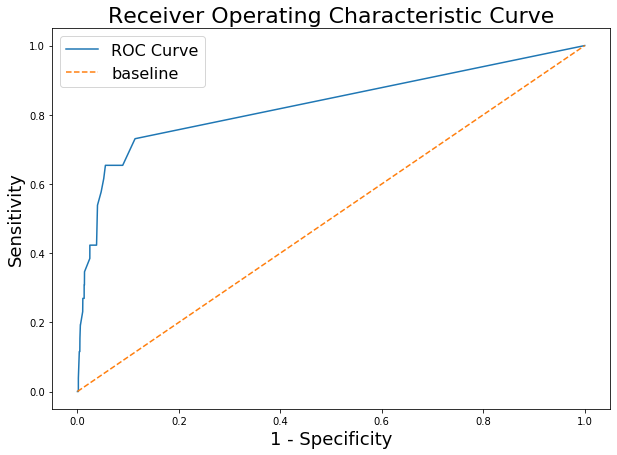

In [16]:
# Create figure.
plt.figure(figsize=(10, 7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)


def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1)
                       & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1)
                        & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity. (False positive rate.)


def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0)
                       & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0)
                        & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))


# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [
    TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]
fpr_values = [
    FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]

# Plot ROC curve.
plt.plot(
    fpr_values,  # False Positive Rate on X-axis
    tpr_values,  # True Positive Rate on Y-axis
    label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)

In [17]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8449102588838262

$$AUC = 0.845$$

## Results

This approach used some hyperparameter tuning: Changing the solver to accomodate `elastic net` and increasing the penalty.  I also considered that the devices that fail run each day up until they fail so the time series could be an important aspect.  The exact date doesn't matter since each there didn't seem to be a direct dependence on the date.  This lead to a significantly better performing model with some predictive power.

In [19]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31098
           1       0.01      0.42      0.03        26

    accuracy                           0.98     31124
   macro avg       0.51      0.70      0.51     31124
weighted avg       1.00      0.98      0.99     31124

